In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime


In [ ]:
df = pd.read_csv("netflix.csv")
closed_prices = df["Close"]
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,23-05-2002,1.242857,1.145714,1.156429,1.196429,104790000,1.196429
1,24-05-2002,1.225000,1.197143,1.214286,1.210000,11104800,1.210000
2,28-05-2002,1.232143,1.157143,1.213571,1.157143,6609400,1.157143
3,29-05-2002,1.164286,1.085714,1.164286,1.103571,6757800,1.103571
4,30-05-2002,1.107857,1.071429,1.107857,1.071429,10154200,1.071429


In [ ]:
df1=df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4881 entries, 0 to 4880
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4881 non-null   object 
 1   High       4881 non-null   float64
 2   Low        4881 non-null   float64
 3   Open       4881 non-null   float64
 4   Close      4881 non-null   float64
 5   Volume     4881 non-null   int64  
 6   Adj Close  4881 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 267.1+ KB


In [ ]:
mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

In [ ]:
seq_len = 15
X = []
y = []

In [ ]:
for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[... , None]
y = np.array(y)[... , None]

In [ ]:
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

In [ ]:
class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

In [ ]:
optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

In [ ]:
num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

10 epoch loss 0.0045103705
20 epoch loss 0.004615473
30 epoch loss 0.0044070953
40 epoch loss 0.0036651264
50 epoch loss 0.0032739027
60 epoch loss 0.0026315295
70 epoch loss 0.0016302051
80 epoch loss 0.00021379016
90 epoch loss 0.0002441525


In [ ]:
model.eval()
with torch.no_grad():
    output = model(test_x)

In [ ]:
pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

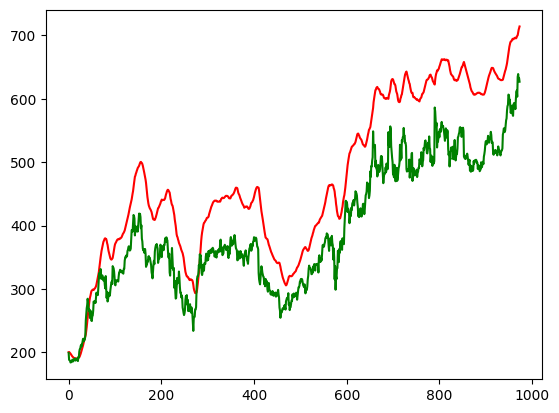

In [ ]:
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.show()

In [ ]:
df=df1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4881 entries, 0 to 4880
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4881 non-null   object 
 1   High       4881 non-null   float64
 2   Low        4881 non-null   float64
 3   Open       4881 non-null   float64
 4   Close      4881 non-null   float64
 5   Volume     4881 non-null   int64  
 6   Adj Close  4881 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 267.1+ KB


In [ ]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4881.000000,4881.000000,4881.000000,4881.000000,4.881000e+03,4881.000000
mean,107.003361,103.742674,105.388477,105.434149,1.679949e+07,105.434149
std,159.326383,154.662309,157.007060,157.073188,1.936794e+07,157.073188
min,0.410714,0.346429,0.377857,0.372857,2.856000e+05,0.372857
25%,3.977143,3.838571,3.901429,3.906429,6.286300e+06,3.906429
50%,22.261429,21.150000,21.524286,21.632856,1.082310e+07,21.632856
75%,127.430000,123.589996,125.949997,125.389999,2.015640e+07,125.389999
max,646.840027,630.859985,642.229981,639.099976,3.234140e+08,639.099976


In [ ]:
df.Date= pd.to_datetime(df.Date)
df2 =df.set_index('Date')

<ipython-input-42-6abccfb87ac4>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df.Date= pd.to_datetime(df.Date)


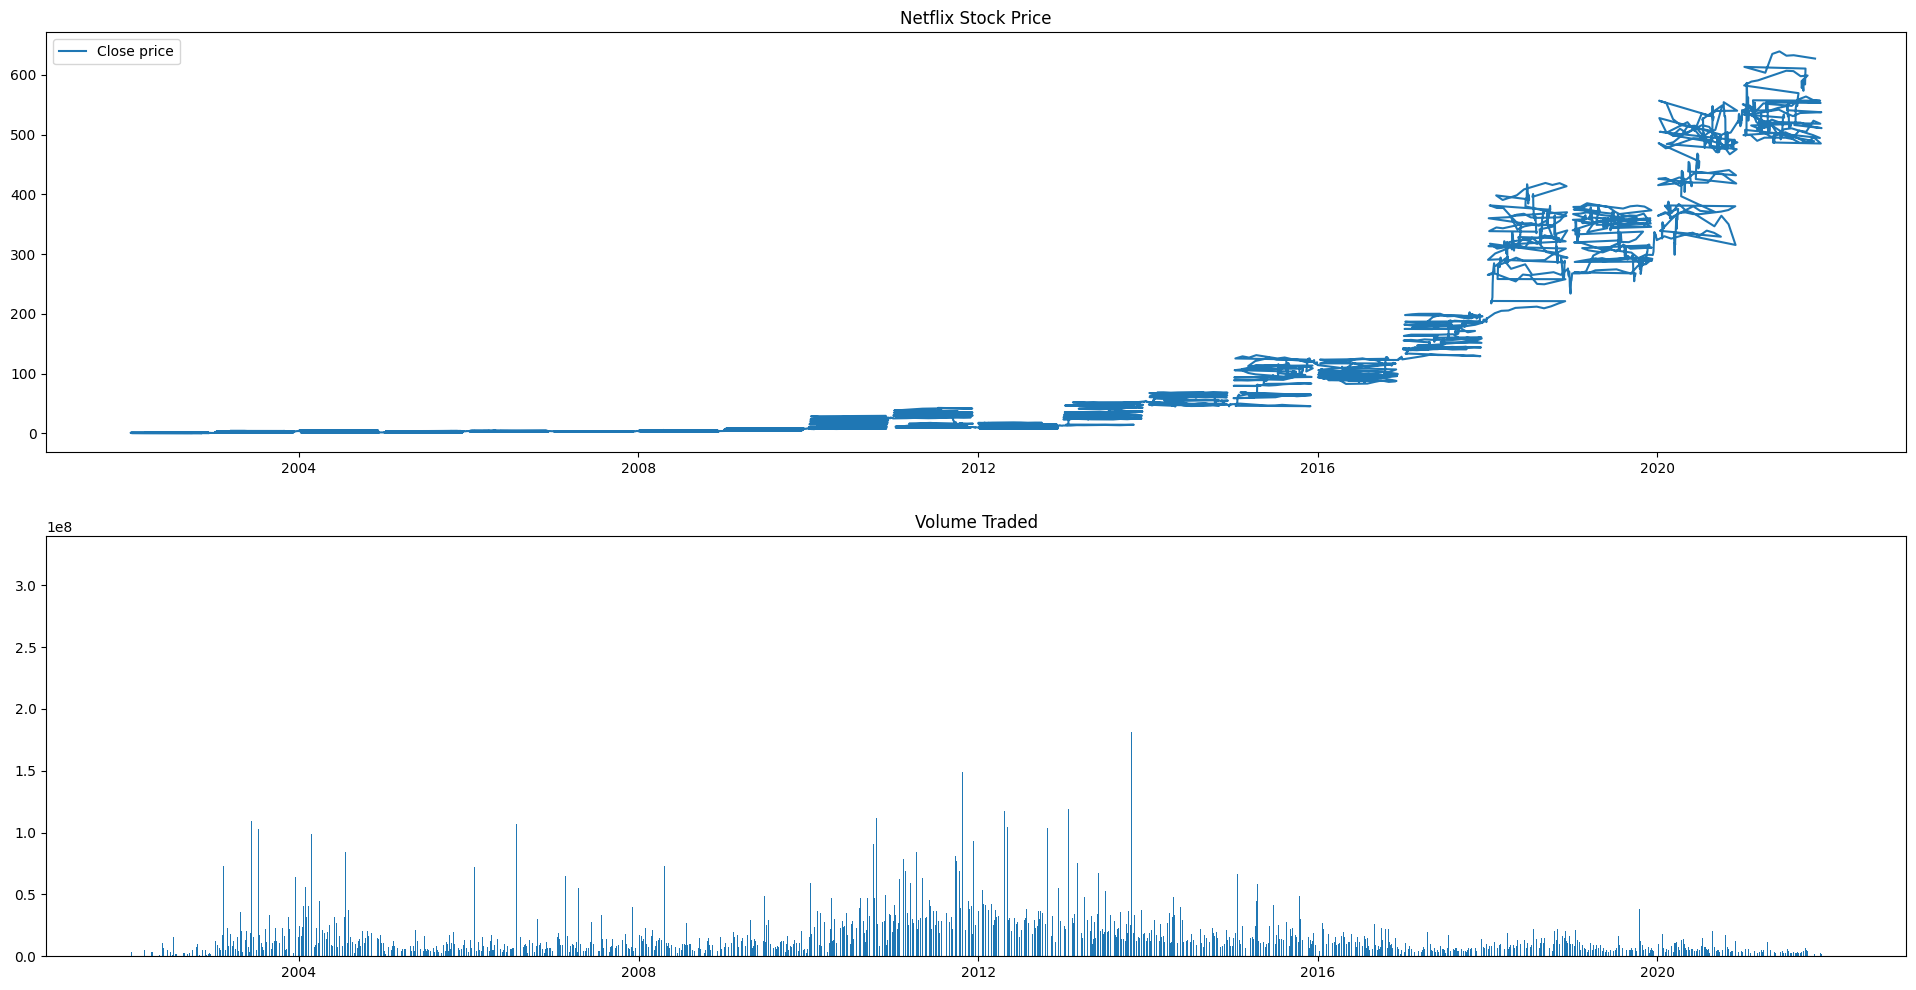

In [ ]:
plt.figure(figsize=(24,12))
plt.subplot(2, 1, 1)
plt.title('Netflix Stock Price')
plt.plot(df2.Close,label='Close price')
plt.legend()
plt.subplot(2, 1, 2)
plt.title('Volume Traded')
plt.bar(x=df2.index,height=df2['Volume'])
plt.show()

In [ ]:
data = list(df2["Close"])

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data)
print("1. ADF : ",result[0])
print("2. P-Value : ", result[1])
print("3. Num Of Lags : ", result[2])
print("4. Num Of Observations Used For ADF Regression:", result[3])
print("5. Critical Values :")
for key, val in result[4].items():
  print("\t",key, ": ", val)

1. ADF :  2.9480813645189707
2. P-Value :  1.0
3. Num Of Lags :  30
4. Num Of Observations Used For ADF Regression: 4850
5. Critical Values :
	 1% :  -3.4316990235892413
	 5% :  -2.8621361184931735
	 10% :  -2.5670873152938674


In [ ]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(data,test = "adf")
print("d value:", d_value)

d value: 1


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [ ]:
x_train= data[:-100]
x_test = data[-100:]
print(len(x_train),len(x_test))

4781 100


In [ ]:
stepwise_fit = auto_arima(data,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=5.93 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=32684.455, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=30901.140, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=30316.525, Time=0.44 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=29758.935, Time=0.59 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=29694.525, Time=0.75 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=29614.869, Time=0.86 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=6.18 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=4.41 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=29616.869, Time=2.22 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 22.624 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4881
Model:  

In [ ]:
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(data, order=(5,2,0))

In [ ]:
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4881
Model:                 ARIMA(5, 2, 0)   Log Likelihood              -14801.435
Date:                Thu, 17 Aug 2023   AIC                          29614.869
Time:                        12:32:33   BIC                          29653.826
Sample:                             0   HQIC                         29628.540
                               - 4881                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9041      0.006   -154.318      0.000      -0.916      -0.893
ar.L2         -0.7032      0.008    -91.826      0.000      -0.718      -0.688
ar.L3         -0.5122      0.008    -63.793      0.000      -0.528      -0.496
ar.L4         -0.2317      0.007    -34.896      0.000      -0.245      -0.219
ar.L5         -0.1295      0.005    -24.890      0.000      -0.140      -0.119
sigma2        25.2618      0.129    196.042      0.000      25.009      25.514
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):            222182.32
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):            4125.62   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
start=len(x_train)
end=len(x_train)+len(x_test)-1
pred = model.predict(start=start,end=end)
pred

array([487.20182093, 502.44697932, 500.27613278, 504.84139025,
       505.19510208, 503.65219567, 506.73890885, 502.79049452,
       499.57334987, 498.62827957, 487.80030766, 492.34868312,
       493.37369354, 489.95176104, 485.21562642, 484.9040968 ,
       487.99314936, 499.44790509, 493.09839987, 492.69485639,
       500.94689293, 501.38118496, 499.0258369 , 510.34053352,
       516.1248315 , 521.57357864, 532.99661555, 538.24740892,
       539.88700718, 532.51448975, 536.35922483, 535.99061801,
       542.81631741, 538.05439415, 530.56616543, 537.23464861,
       536.73979227, 541.21978661, 549.77554717, 544.80852739,
       531.23924516, 531.53001339, 528.69075235, 508.9737249 ,
       506.46958973, 510.27789401, 512.21228604, 517.59276319,
       518.605324  , 514.74059968, 518.20848784, 515.11739963,
       509.48921034, 517.10937621, 525.10457681, 521.86411687,
       521.55816312, 516.72066532, 511.5281821 , 509.44904869,
       513.64402174, 517.37360952, 519.04220212, 523.57

In [ ]:
s = pd.Series(pred, index =df2.index[-100:])
s

Date
2021-05-20    487.201821
2021-05-21    502.446979
2021-05-24    500.276133
2021-05-25    504.841390
2021-05-26    505.195102
                 ...    
2021-05-10    608.530440
2021-06-10    639.973454
2021-07-10    647.872304
2021-08-10    637.023716
2021-11-10    640.287839
Length: 100, dtype: float64

<Axes: xlabel='Date'>

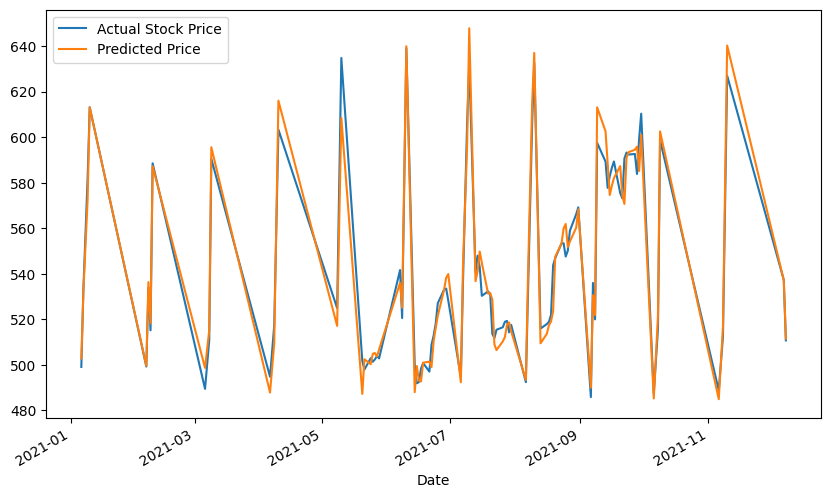

In [ ]:
plt.figure(figsize=(10,6), dpi=100)
df2['Close'][-100:].plot(label='Actual Stock Price', legend=True)
s.plot(label='Predicted Price', legend=True,)

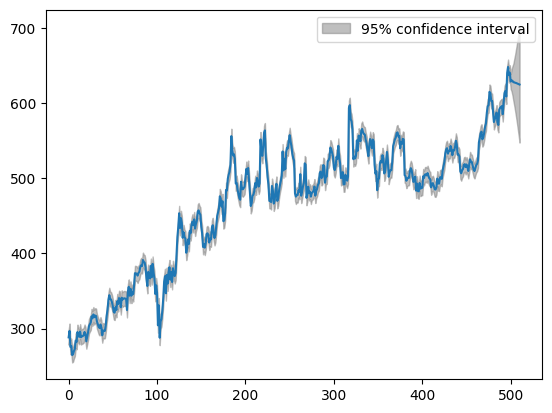

In [ ]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model, start = len(data)-500, end = len(data)+10, dynamic = False);

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(x_test,pred))

7.891925312771997

In [ ]:
from sklearn.metrics import r2_score
r2_score(x_test,pred)

0.9629335372832918